In [8]:
%autosave 60

Autosaving every 60 seconds


In [9]:
import os
import h3
import sys

import pandas as pd
import numpy as np
from scipy.stats import zscore
import json
import matplotlib.pyplot as plt

In [10]:
plt.rcParams.update({'font.size': 18})

In [11]:
import pandahouse # Для чтения из ClickHouse
from getpass import getpass

In [12]:
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPolygon
from scipy.spatial.distance import euclidean
from shapely.geometry import MultiPoint
from shapely import wkt
from typing import Union
from keplergl import KeplerGl
from shapely.ops import cascaded_union

In [13]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [14]:
pd.set_option('display.max_columns', 500)

In [15]:
# NEW
configClickHouseBI = { # ClickHouse
    'host': 'http://chbi-vip.city-srv.ru:8123',
#     'host': 'http://chmain-vip.city-srv.ru:8123',
    'user': 'm.shalankin',
    'password': getpass('enter pass for CH BI')
}

enter pass for CH BI········


In [16]:
city = 22426
date_start = '2021-12-31 20:00:00'
date_end = '2022-01-01 04:00:00'

ch_geo_host = '192.168.61.137'

In [17]:
dates_to_load = [
    ['2021-11-26 17:00:00', '2021-11-26 23:59:59'],
    ['2021-11-19 17:00:00', '2021-11-19 23:59:59'],
    ['2021-11-12 17:00:00', '2021-11-12 23:59:59'],
    ['2021-11-05 17:00:00', '2021-11-05 23:59:59'],
    ['2021-10-29 17:00:00', '2021-10-29 23:59:59'],
    ['2021-10-22 17:00:00', '2021-10-22 23:59:59'],
    ['2021-10-15 17:00:00', '2021-10-15 23:59:59'],
    ['2021-10-08 17:00:00', '2021-10-08 23:59:59'],
    ['2021-10-01 17:00:00', '2021-10-01 23:59:59'],
    ['2021-09-03 17:00:00', '2021-09-03 23:59:59'],
    ['2021-09-10 17:00:00', '2021-09-10 23:59:59'],
    ['2021-09-17 17:00:00', '2021-09-17 23:59:59'],
    ['2021-09-24 17:00:00', '2021-09-24 23:59:59'],
]

In [ ]:
results_dfs = []

for date_pair in tqdm(dates_to_load):

    query = f"""select * from (
                      select * from (
                      select
                                  id
                                  , OrderedDate
                                  , toString(idhash) as idhash
                                  , GoodArrived
                                  , ClientCollected
                                  , GoodArrived
                                  , GoodArrived - ClientCollected as RTA, main_id_locality, latitude, longitude, del_latitude, del_longitude
                                  from rt_city_import.order_closed final
                                  where OrderedDate between toDateTime('{date_pair[0]}') - interval 2 minute and toDateTime('{date_pair[1]}') + interval 2 minute
                                  and status = 'CP'
                                  and main_id_locality = {city}
                                  and toInt64(companyid) global in
                                    (select id from rt_city_import.company final where id_account = 1)
                                  and g_type != 1
                                  and datediff('minute', OrderedDate, ClientCollected) < 60
                                  and id_client > 0
                                  and source = 'A'
                                  and hurry = 'Y'
                                  and CollAddrTypeMenu != 2
                                  and CollAddrTypeMenu != 3
                                  and tariff != 7087
                                  and tariff global not in (select toInt64(id)
                                  from etl_city_import.tariff_group
                                  where tariff_group = 'доставка')
                          ) t1
                      global any left join
                          (
                                     select *
                                     from (
                                              select original_eta,
                                                     correct_eta,
                                                     distance,
                                                     departure,
                                                     num_provider,
                                                     locality_id,
                                                     route_id,
                                                     date_added,
                                                     calculation_id
                                              from remote('{ch_geo_host}', kafka_georouting, georouting_routes, '{ch_geo_user}', '{ch_geo_password}')
                                              where 1 = 1
                                                and locality_id = {city}
                                                and num_provider != 3
                                                and calculation_id != ''
                                                and route_id != ''
                                                and date_added between toDateTime('{date_pair[0]}') - interval 2 minute and toDateTime('{date_pair[1]}') + interval 2 minute
                                              ) tt1
                                              global any
                                              join
                                          (
                                              select original_value,
                                                     processed_value,
                                                     route_id,
                                                     trace_id
                                              from remote('{ch_geo_host}', eta_rta_stat_new, eta_rta_stat_data, '{ch_geo_user}', '{ch_geo_password}')
                                              where 1 = 1
                                                and type_id = 1
                                                and date_time_moscow between toDateTime('{date_pair[0]}') - interval 2 minute and toDateTime('{date_pair[1]}') + interval 2 minute
                                                and location_id = {city}
                                                and original_value > 0
                                                and processed_value > 0
                                                and route_id != ''
                                              ) tt2
                                          on tt1.calculation_id = tt2.trace_id
                                              and tt1.route_id = tt2.route_id
                                        ) t2
                                        on t1.idhash = t2.calculation_id
                                        where 1 = 1
                      and RTA > 0
                      and original_value > 0
                      and processed_value > 0
                      and original_eta > 0
                      and correct_eta > 0
                      and main_id_locality = {city}

                      ) LTF

                      global any left join
                          (
                              select
                                     id,
                                     last_lat,
                                     last_lon,
                                     distance + service_way2 as RDA
                              from rt_city_import.order_control_closed
                              where 1 = 1
                              and date_updated between toDateTime('{date_pair[0]}') - interval 2 minute and toDateTime('{date_pair[1]}') + interval 240 minute

                              ) RTF
                              on LTF.id = RTF.id

                              """
    
    try:
        df = pd.read_table(pandahouse.execute(
            query + ' FORMAT TSVWithNames', 
            connection=configClickHouseBI, 
            stream=True)
                          )
    except:
        
        time.sleep(np.random.randint(5, 10))
        
        df = pd.read_table(pandahouse.execute(
            query + ' FORMAT TSVWithNames', 
            connection=configClickHouseBI, 
            stream=True))
        
    
    if df.shape[0] == 0:
        print('empty')
        continue
        
        
    results_dfs.append(df)


In [ ]:
df = pd.concat(results_dfs, axis=0)

In [ ]:
# query = f"""select * from (
#                   select * from (
#                   select
#                               id
#                               , OrderedDate
#                               , toString(idhash) as idhash
#                               , GoodArrived
#                               , ClientCollected
#                               , GoodArrived
#                               , GoodArrived - ClientCollected as RTA, main_id_locality, latitude, longitude, del_latitude, del_longitude
#                               from rt_city_import.order_closed final
#                               where OrderedDate between toDateTime('{date_start}') - interval 2 minute and toDateTime('{date_end}') + interval 2 minute
#                               and status = 'CP'
#                               and main_id_locality = {city}
#                               and toInt64(companyid) global in
#                                 (select id from rt_city_import.company final where id_account = 1)
#                               and g_type != 1
#                               and datediff('minute', OrderedDate, ClientCollected) < 60
#                               and id_client > 0
#                               and source = 'A'
#                               and hurry = 'Y'
#                               and CollAddrTypeMenu != 2
#                               and CollAddrTypeMenu != 3
#                               and tariff != 7087
#                               and tariff global not in (select toInt64(id)
#                               from etl_city_import.tariff_group
#                               where tariff_group = 'доставка')
#                       ) t1
#                   global any left join
#                       (
#                                  select *
#                                  from (
#                                           select original_eta,
#                                                  correct_eta,
#                                                  distance,
#                                                  departure,
#                                                  num_provider,
#                                                  locality_id,
#                                                  route_id,
#                                                  date_added,
#                                                  calculation_id
#                                           from remote('{ch_geo_host}', kafka_georouting, georouting_routes, '{ch_geo_user}', '{ch_geo_password}')
#                                           where 1 = 1
#                                             and locality_id = {city}
#                                             and num_provider != 3
#                                             and calculation_id != ''
#                                             and route_id != ''
#                                             and date_added between toDateTime('{date_start}') - interval 2 minute and toDateTime('{date_end}') + interval 2 minute
#                                           ) tt1
#                                           global any
#                                           join
#                                       (
#                                           select original_value,
#                                                  processed_value,
#                                                  route_id,
#                                                  trace_id
#                                           from remote('{ch_geo_host}', eta_rta_stat_new, eta_rta_stat_data, '{ch_geo_user}', '{ch_geo_password}')
#                                           where 1 = 1
#                                             and type_id = 1
#                                             and date_time_moscow between toDateTime('{date_start}') - interval 2 minute and toDateTime('{date_end}') + interval 2 minute
#                                             and location_id = {city}
#                                             and original_value > 0
#                                             and processed_value > 0
#                                             and route_id != ''
#                                           ) tt2
#                                       on tt1.calculation_id = tt2.trace_id
#                                           and tt1.route_id = tt2.route_id
#                                     ) t2
#                                     on t1.idhash = t2.calculation_id
#                                     where 1 = 1
#                   and RTA > 0
#                   and original_value > 0
#                   and processed_value > 0
#                   and original_eta > 0
#                   and correct_eta > 0
#                   and main_id_locality = {city}

#                   ) LTF

#                   global any left join
#                       (
#                           select
#                                  id,
#                                  last_lat,
#                                  last_lon,
#                                  distance + service_way2 as RDA
#                           from rt_city_import.order_control_closed
#                           where 1 = 1
#                           and date_updated between toDateTime('{date_start}') - interval 2 minute and toDateTime('{date_end}') + interval 240 minute

#                           ) RTF
#                           on LTF.id = RTF.id
                          
#                           """


In [ ]:
df = pd.read_table(
    pandahouse.execute(
        query + ' FORMAT TSVWithNames', 
        connection=configClickHouseBI, 
        stream=True
    )
)

In [ ]:
df.to_csv('../data/data_6_to_6_spb.csv', index=False)

In [ ]:
df.to_csv('../data/data_fridays_22426.csv', index=False)

### preproc

In [18]:
df = pd.read_csv('../data/data_fridays_22426.csv')

In [19]:
print(df.shape)

(83006, 28)


In [20]:
df['GoodArrived'] = pd.to_datetime(df['GoodArrived'])

In [21]:
df = df[df['RDA'] != '\\N'].reset_index(drop=True).copy()

In [22]:
df['RDA'] = df['RDA'].astype(float)

In [23]:
df = df[(df['RDA'] > 0) & (df['distance'] > 0)].reset_index(drop=True).copy()

In [24]:
df = df[df['RTA'] > 0].reset_index(drop=True).copy()

In [25]:
# Выбросы по метрике EDA / RDA

df = df[abs(zscore(((df['distance'] / 1000) / df['RDA']))) <= 3].reset_index(drop=True).copy()

In [26]:
df = df[
    (df['latitude'] > 0.1) 
    & (df['longitude'] > 0.1) 
    & (df['del_latitude'] > 0.1) 
    & (df['del_longitude'] > 0.1)
].reset_index(drop=True).copy()

In [27]:
# myconf = map_2.config

In [28]:
# map_2 = KeplerGl(height=700, config=myconf)
# map_2.add_data(df[['GoodArrived', 'del_latitude', 'del_longitude']], name='s1')
# map_2

In [29]:
df['h3_kepler_'] = df.progress_apply(
    lambda x: h3.geo_to_h3(x['del_latitude'], x['del_longitude'], 8), axis=1
)

  0%|          | 0/82645 [00:00<?, ?it/s]

In [30]:
df['time_hour_index'] = df.progress_apply(
    lambda x: x['GoodArrived'].hour + 24 if x['GoodArrived'].year == 2022 else x['GoodArrived'].hour
    , axis=1
)

  0%|          | 0/82645 [00:00<?, ?it/s]

In [31]:
# df = df[df['time_hour_index'] != df['time_hour_index'].max()].reset_index(drop=True).copy()

In [32]:
df_time_and_freq = pd.DataFrame(
    df.groupby(['time_hour_index', 'h3_kepler_'])['h3_kepler_'].count()
).rename({"h3_kepler_": 'freq'}, axis=1).reset_index(drop=False)

In [33]:
df_time_and_freq.head(2)
df_time_and_freq = df_time_and_freq[df_time_and_freq['time_hour_index'] != df_time_and_freq['time_hour_index'].max()].reset_index(drop=True).copy()

In [34]:
# conf_2 = map_2.config

In [35]:
# map_2 = KeplerGl(height=700) # , config=conf_2)
# map_2.add_data(df_time_and_freq, name='s1')
# map_2

# Check clusters here

In [37]:
# map_2 = KeplerGl(height=700) # , config=conf_2)
# map_2.add_data(df[['del_latitude', 'del_longitude']], name='s1')
# map_2

* Часть первая — Affinity Propagation
* Часть вторая — DBSCAN
* Часть третья — кластеризация временных рядов
* Часть четвёртая — Self-Organizing Maps (SOM)
* Часть пятая — Growing Neural Gas (GNG)

* cluster.AffinityPropagation
* cluster.AgglomerativeClustering
* cluster.Birch
* cluster.DBSCAN
* cluster.FeatureAgglomeration
* cluster.KMeans
* cluster.MiniBatchKMeans
* cluster.MeanShift
* cluster.OPTICS
* cluster.SpectralClustering
* cluster.SpectralBiclustering
* cluster.SpectralCoclustering

## Types of Clustering

* Centroid-based Clustering
* Density-based Clustering
* Distribution-based Clustering
* Hierarchical Clustering


# Clustering Algorithms
* Centroid-based clustering
  * k-means
  * k-means++
  * k-means||
  * Fuzzy C-means
  * k-medoids, PAM
  * k-Medians
  * k-Modes
  * k-prototypes
  * CLARA
  * CLARANS
* Distribution-based clustering
  * GMM
  * EM
  * DMM
* Density-based clustering
  * DBSCAN
  * ADBSCAN
  * DENCLUE
  * OPTICS

# Clustering Algorithms
* centroid - based
    * k-means
    * k-modes
    * k-medians
    * CLARA
    * CLARANS
    
* distribution - based
    * EM
    * GMM
    * DMM
    * DBCLASD
    * 
* density - based
    * OPTIC
    * ADBSCAN
    * DENCLUE
    * 
* connectivity - based
    * BIRCH
    * DIANA
    * BICO
    * CURE
    * 
* graph - based
    * k-spanning tree
    * shared nearest neighbor
    * betweenness
    * 
* grid - based
    * Wavecluster
    * sting
    * clique
    * vdbscan
* fractal - based
    * FractStream
    * FC
    *
* kernel - based
    * k-means
    * som
    * neural gas
    * probabilistic c-means
* quantum - based
    * QC
    * DQC

# Algos

In [38]:
from sklearn.mixture import GaussianMixture
from tqdm import tqdm

In [39]:
# # TIME BEFORE NEW YEAR
# df = df[df['GoodArrived'].dt.year != 2022].reset_index(drop=True).copy()

In [41]:
# # TIME AFTER NEW YEAR
# df = df[df['GoodArrived'].dt.year == 2022].reset_index(drop=True).copy()

In [42]:
# Вариант удалени выбросов 1

# df = df[
#     (abs(zscore(df['del_latitude'])) <= 3) & (abs(zscore(df['del_longitude'])) <= 3)
# ].reset_index(drop=True).copy()

# KMeans

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
KMeans

## GaussianMixture 

In [ ]:
n_components = np.arange(10, 30)
models = [
    GaussianMixture(n, covariance_type='spherical', random_state=0).fit(df[['del_latitude', 'del_longitude']].values) 
    for n in tqdm(n_components)
]

In [ ]:
plt.plot(n_components, [m.bic(df[['del_latitude', 'del_longitude']].values) for m in models], label='BIC')
plt.plot(n_components, [m.aic(df[['del_latitude', 'del_longitude']].values) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

In [ ]:
gmm = GaussianMixture(n_components=22, covariance_type='spherical')
gmm.fit(df[['del_latitude', 'del_longitude']].values)
labels = gmm.predict(df[['del_latitude', 'del_longitude']].values)

In [ ]:
df['cluster'] = labels

In [ ]:
df['cluster'].nunique()

In [ ]:
# map_2 = KeplerGl(height=700) # , config=conf_2)
# map_2.add_data(df[['del_latitude', 'del_longitude', 'cluster']], name='s1')
# map_2


# DEL ? 

In [ ]:
# map_2 = KeplerGl(height=700) # , config=conf_2)
# map_2.add_data(df[['del_latitude', 'del_longitude']], name='s1')
# map_2

In [ ]:
# df

# METRICS: WCSS

In [ ]:
def calc_wcss(lat_lon_array_one_cluster):
    """Within-Cluster-Sum-of-Squares.
    For one array cluster.
    lower - better"""
    
    lat_center = round(lat_lon_array_one_cluster[:, 0].mean(), 6)
    lon_center = round(lat_lon_array_one_cluster[:, 1].mean(), 6)
    
    wcss = np.sum(np.linalg.norm(lat_lon_array_one_cluster - np.array([lat_center, lon_center])))
    return wcss

In [ ]:
total_wcss = 0
for cluster_id in df['cluster'].unique():
    total_wcss += calc_wcss(df[df['cluster'] == cluster_id][['del_latitude', 'del_longitude']].values)
    
print(f"Within-Cluster-Sum-of-Squares: {round(total_wcss, 2)}")

# METRIC: Average Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
def calc_avgss(lat_lon_array_one_cluster, label_array):
    """Average Silhouette Score.
    bigger - better"""
    
    return silhouette_score(lat_lon_array_one_cluster, label_array)

In [ ]:
print(f"Average Silhouette Score: {round(calc_avgss(df[['del_latitude', 'del_longitude']].values, df['cluster'].values), 4)}")

# DBSCAN

In [ ]:
import  pandas  as pd
import  numpy as np
import  matplotlib.pyplot  as plt
from  sklearn.cluster  import  DBSCAN
from  geopy.distance  import  great_circle
from  shapely.geometry  import  MultiPoint
        

coords = df[['del_latitude', 'del_longitude']].values

In [ ]:
kms_per_radian = 6371.00882

epsilon = 0.25 / kms_per_radian

db = DBSCAN(eps=epsilon,
            min_samples=1,
            algorithm='ball_tree',
            metric='haversine',
           ).fit(np.radians(coords))
cluster_labels = db.labels_

In [ ]:
len(np.unique(cluster_labels))

In [ ]:
df['cluster'] = cluster_labels
df['cluster'] = df['cluster'].astype(str)
df['cluster'] += '_cluster'

In [ ]:
# res_dict = {}
# for cluster_name in tqdm(set(df['cluster'].unique()) - set(['-1_cluster'])):
    
#     coords = df[df['cluster'] == cluster_name][['del_longitude', 'del_latitude']].values
    
    
#     if cluster_name in [
# #         '0_cluster', 
#     ]:
#         continue
#     try:
        
#         alpha_shape = libpysal.cg.alpha_shape_auto(coords)
#         res_dict[cluster_name] = str(alpha_shape)
    
#     except:
#         print(len(coords))

In [ ]:
map_2 = KeplerGl(height=700) # , config=config_cluster)
# map_2.add_data(df[['del_latitude', 'del_longitude', 'cluster']], name='s2')
map_2.add_data(df[df['cluster'] != '-1_cluster'][['del_latitude', 'del_longitude', 'cluster']], name='s2')

In [ ]:
# map_2

# HDBSCAN

In [ ]:
import hdbscan

In [ ]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=750, 
    leaf_size=10, 
    cluster_selection_epsilon=0.0014, 
    algorithm='boruvka_kdtree'
)

cluster_labels = clusterer.fit_predict(data[['lat', 'lon']].values)

# OPTICS

In [ ]:
from sklearn.cluster import OPTICS

In [ ]:
# conf_2 = map_2.config

In [ ]:
# map_2 = KeplerGl(height=700, config=conf_2)
# map_2.add_data(df[['del_latitude', 'del_longitude']], name='s1')
# map_2

In [ ]:
# algorithm : {'auto', 'ball_tree', 'kd_tree', 'brute'}

In [ ]:
# df = df[df['cluster'] == '0_cluster'].reset_index(drop=True).copy()

In [ ]:
clr = OPTICS(
    min_cluster_size=int(df.shape[0] * 0.05), 
    cluster_method='dbscan',
    max_eps=0.004,
    metric='euclidean'
)

# metric='euclidean', min_cluster_size=int(df.shape[0] * 0.03), cluster_method='dbscan', eps=0.01)

In [ ]:
from sklearn.cluster import OPTICS

clr = OPTICS(
    min_cluster_size=int(df.shape[0] * 0.05), 
    cluster_method='dbscan',
    max_eps=0.004,
    metric='euclidean'
)
df['cluster'] = clr.fit_predict(df[['del_latitude', 'del_longitude']].values)

In [ ]:
%%time
labels = clr.fit_predict(df[['del_latitude', 'del_longitude']].values)
print(len(np.unique(labels)))

In [ ]:
df['cluster'] = labels
df['cluster'] = df['cluster'].astype(str)
df['cluster'] += '_cluster'

In [ ]:
# config_cluster = map_2.config

In [ ]:
# map_2 = KeplerGl(height=700, config=config_cluster)
# # map_2.add_data(df[['del_latitude', 'del_longitude', 'cluster']], name='s2')
# map_2.add_data(df[df['cluster'] != '-1_cluster'][['del_latitude', 'del_longitude', 'cluster']], name='s2')
# map_2

In [ ]:
import libpysal

In [ ]:
res_dict = {}
for cluster_name in set(df['cluster'].unique()) - set(['1_cluster']):
    
    coords = df[df['cluster'] == cluster_name][['del_longitude', 'del_latitude']].values
    
    try:
        
        alpha_shape = libpysal.cg.alpha_shape_auto(coords)
        res_dict[cluster_name] = str(alpha_shape)
    
    except:
        print(len(coords))

In [ ]:
# map_2 = KeplerGl(height=700, config=config_cluster)
# # map_2.add_data(df[['del_latitude', 'del_longitude', 'cluster']], name='s2')
# map_2.add_data(df[df['cluster'] != '-1_cluster'][['del_latitude', 'del_longitude', 'cluster']], name='s2')

# map_2.add_data(pd.DataFrame(pd.Series(res_dict)).reset_index(drop=False).rename({0: 'f'}, axis=1), name='s1')


# AgglomerativeClustering

In [ ]:
plt.rcParams.update({'font.size': 12})

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
# {'ward', 'complete', 'average', 'single'}

In [ ]:
# Посчитать оптимальное число кластеров по метрике

all_cluster_sizes = np.arange(10, 41, 1)
all_wcss = []
all_avgss = []

for cluster_size in tqdm(all_cluster_sizes):
    
    clr = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward')
    df['cluster'] = clr.fit_predict(np.radians(df[['del_latitude', 'del_longitude']].values))
    
    
    # CALC metrics
    
    # Metric 1
    total_wcss = 0
    for cluster_id in df['cluster'].unique():
        total_wcss += calc_wcss(df[df['cluster'] == cluster_id][['del_latitude', 'del_longitude']].values)

    wcss = round(total_wcss, 2)

    # Metric 2
    avgss = round(calc_avgss(df[['del_latitude', 'del_longitude']].values, df['cluster'].values), 4)
    
    
    all_wcss.append(wcss)
    all_avgss.append(avgss)

In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.set_xlabel('число кластеров')
ax1.set_ylabel('значение метрики avg_ss', color='#985578')
ax1.plot(all_cluster_sizes, all_avgss, linewidth=3, color='#985578', label='Average Silhouette Score')
ax1.tick_params(axis='y', labelcolor='#985578')

ax2 = ax1.twinx()
ax2.set_ylabel('значение метрики wcss', color='#8C14AA')
ax2.plot(all_cluster_sizes, all_wcss, linewidth=3, color='#8C14AA', label='Within-Cluster-Sum-of-Squares')
ax2.tick_params(axis='y', labelcolor='#8C14AA')

plt.title('Метрики кластеризации для Agglomerative Clustering [ward]')
plt.xticks(all_cluster_sizes)
ax1.grid()
ax2.grid()
fig.legend()
plt.show()


In [ ]:
# 12; 18; 23

In [ ]:
clr = AgglomerativeClustering(n_clusters=31, linkage='average')

In [ ]:
df['cluster'] = clr.fit_predict(np.radians(df[['del_latitude', 'del_longitude']].values))

In [ ]:
df['cluster'] = df['cluster'].astype(str)
df['cluster'] += '_cluster'

In [ ]:
# map_2 = KeplerGl(height=700, config=config_cluster)
# # map_2.add_data(df[['del_latitude', 'del_longitude', 'cluster']], name='s2')
# map_2.add_data(df[df['cluster'] != '-1_cluster'][['del_latitude', 'del_longitude', 'cluster']], name='s2')
# map_2

In [ ]:
res_dict = {}
for cluster_name in tqdm(set(df['cluster'].unique()) - set(['-1_cluster'])):
    
    coords = df[df['cluster'] == cluster_name][['del_longitude', 'del_latitude']].values
    
    
    if cluster_name in [
#         '0_cluster', 
    ]:
        continue
    try:
        
        alpha_shape = libpysal.cg.alpha_shape_auto(coords)
        res_dict[cluster_name] = str(alpha_shape)
    
    except:
        print(len(coords))

In [ ]:
# config_cluster = map_2.config

In [ ]:
map_2 = KeplerGl(height=700, config=config_cluster)
map_2.add_data(df[['del_latitude', 'del_longitude', 'cluster']], name='s2')
# map_2.add_data(df[df['cluster'] != '0_cluster'][['del_latitude', 'del_longitude', 'cluster']], name='s2')

map_2.add_data(pd.DataFrame(pd.Series(res_dict)).reset_index(drop=False).rename({0: 'f'}, axis=1), name='s1')


In [ ]:
# map_2

# Feature Agglomeration

### CHECKER ALGO WORKING

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

In [ ]:
def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float, n_digits: int = 0) -> float:
    """
        Функция для расчёта расстояния от точки А до Б по прямой

        :param lat1: Широта точки А
        :param lon1: Долгота точки А
        :param lat2: Широта точки Б
        :param lon2: Долгота точки Б
        :param n_digits: Округляем полученный ответ до n знака после запятой
        :return: Дистанция по прямой с точностью до n_digits
    """

    lat1, lon1, lat2, lon2 = round(lat1, 6), round(lon1, 6), round(lat2, 6), round(lon2, 6)
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)

    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2

    return round(2 * 6372800 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)), n_digits)  # метры.сантиметры


In [ ]:
lat_1, lon_1 = 30.321187, 59.888312

new_lats, new_lons = [], []

for coords_step in np.power(np.arange(1, 20, 1), 1.7):
    
    multi = (coords_step / 1000000 + 1)  
       
    new_lats.append(lat_1 * multi + (0.0005 * multi))
    new_lons.append(lon_1 * multi)
    
#     new_lats.append(lat_1)
#     new_lons.append(lon_1 * multi)
    
    new_lats.append(lat_1 * multi + (0.0010 * multi))
    new_lons.append(lon_1 * multi)
    
    new_lats.append(lat_1 * multi + (0.0015 * multi))
    new_lons.append(lon_1 * multi)

In [ ]:
print(len(np.power(np.arange(1, 20, 1), 1.7)))

In [ ]:
points = list(zip(new_lats, new_lons))

In [ ]:
zz = pd.DataFrame(pd.Series({'a': str(MultiPoint(points))})).rename({0: 'qq'}, axis=1)

In [ ]:
zz.to_csv('../data/synthetic_points.csv', index=False)

In [ ]:
# confg_synth_points = map_2.config

In [ ]:
map_2 = KeplerGl(height=700, config=confg_synth_points)
map_2.add_data(zz, name='s1')
map_2

In [ ]:
coords = np.array([[i.x, i.y] for i in wkt.loads(zz['qq'][0])])

In [ ]:
# Посчитать оптимальное число кластеров по метрике

all_cluster_sizes = np.arange(2, 20, 1)
all_wcss = []
all_avgss = []

for cluster_size in tqdm(all_cluster_sizes):
    
    clr = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward')
    labels = clr.fit_predict(coords)
    
    
    # CALC metrics
    
    # Metric 1
    total_wcss = 0
    for cluster_id in np.unique(labels):
        total_wcss += calc_wcss(coords[np.where(labels == cluster_id)[0]])

    wcss = round(total_wcss, 2)


    # Metric 2
    avgss = round(calc_avgss(coords, labels), 4)
    
    
    all_wcss.append(wcss)
    all_avgss.append(avgss)

In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.set_xlabel('число кластеров')
ax1.set_ylabel('значение метрики avg_ss', color='#985578')
ax1.plot(all_cluster_sizes, all_avgss, linewidth=3, color='#985578', label='Average Silhouette Score')
ax1.tick_params(axis='y', labelcolor='#985578')

ax2 = ax1.twinx()
ax2.set_ylabel('значение метрики wcss', color='#8C14AA')
ax2.plot(all_cluster_sizes, all_wcss, linewidth=3, color='#8C14AA', label='Within-Cluster-Sum-of-Squares')
ax2.tick_params(axis='y', labelcolor='#8C14AA')

plt.title('Метрики кластеризации для Agglomerative Clustering [ward]')
plt.xticks(all_cluster_sizes)
ax1.grid()
ax2.grid()
fig.legend()
plt.show()


In [ ]:
clr = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels = clr.fit_predict(coords)

In [ ]:
res = {
    'lat': coords[:, 1],
    'lon': coords[:, 0],
    'label': labels,
}

In [ ]:
# map_2 = KeplerGl(height=700)
# map_2.add_data(pd.DataFrame(res), name='s1')
# map_2

# Статья чистовик

In [88]:
piter_raw_poly = [
    [60.19223467251656, 29.94721178554976],
    [60.04307897180814, 29.58191637539351],
    [59.903577802632405, 29.55170397304976],
    [59.79252057774271, 29.852454705471636],
    [59.72415724909631, 30.088660760159136],
    [59.65970546186749, 30.396277947659136],
    [59.69298638813347, 30.637977166409136],
    [59.81059075758129, 30.802772088284136],
    [59.94154168117334, 30.82062487148726],
    [60.092280146475396, 30.648963494534136],
    [60.16614796646701, 30.41962389492476],
]

df['inside_bagel'] = df[['del_latitude', 'del_longitude']].apply(
    lambda x: Polygon(piter_raw_poly).contains(Point([x['del_latitude'], x['del_longitude']])), axis=1).astype(int)


df = df[df['inside_bagel'] == 1].reset_index(drop=True).copy()

In [81]:
df = df.sample(45000).reset_index(drop=True).copy()

In [ ]:
# df.head(1)
# del_latitude, del_longitude

## Метрики 
* Что за метрики и как их будем считать 

### Within-Cluster-Sum-of-Squares

In [44]:
# python реализация
import numpy as np


def wcss_score(X, labels):

    """
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        A list of ``n_features``-dimensional data points. Each row corresponds
        to a single data point.

    labels : array-like of shape (n_samples,)
        Predicted labels for each sample.

    Returns
    -------
    score: float
        The resulting average within cluster sum of Squares
    """
    
    total_wcss = 0
    unique_labels = np.unique(labels)
    
    for cluster_label in unique_labels:
        cluster_indexes = np.where(labels == cluster_label)[0]
        total_wcss += np.sum(np.linalg.norm(np.mean(X[cluster_indexes], axis=0) - X[cluster_indexes], axis=1))
    
    return total_wcss / len(unique_labels)

### Average Silhouette Score

In [45]:
# Average Silhouette Score

from sklearn.metrics import silhouette_score

### Calinski-Harabasz Index
Calinski-Harabasz Index is also known as the Variance Ratio Criterion.
The score is defined as the ratio between the within-cluster dispersion and the between-cluster dispersion. The C-H Index is a great way to evaluate the performance of a Clustering algorithm as it does not require information on the ground truth labels.
The higher the Index, the better the performance.


In [46]:
from sklearn.metrics import calinski_harabasz_score

### Davies-Bouldin Index
The Davies-Bouldin Index is defined as the average similarity measure of each cluster with its most similar cluster. Similarity is the ratio of within-cluster distances to between-cluster distances. In this way, clusters which are farther apart and less dispersed will lead to a better score.
The minimum score is zero, and differently from most performance metrics, the lower values the better clustering performance.

In [47]:
from sklearn.metrics import davies_bouldin_score

In [101]:
def calc_all_metrics(X, labels):
    """Функция-помощник для статьи"""
    
    return {
        'average within cluster sum of squares': round(wcss_score(X, labels), 4),
        'average silhouette score': round(silhouette_score(X, labels), 4),
        'calinski-harabasz index': round(calinski_harabasz_score(X, labels), 4),
        'davies-bouldin index': round(davies_bouldin_score(X, labels), 4),   
    }

In [55]:
%%time
# calc_all_metrics(df[['del_latitude', 'del_longitude']].values, df['cluster_label'].values)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 4.29 µs


## Алгоритм 1

* centroid - based
* KMeans

In [56]:
from sklearn.cluster import KMeans

In [ ]:
res_scores = {}

cluster_count = np.arange(5, 31, 1)

for n_clusters in tqdm(cluster_count):
    cluster_model = KMeans(n_clusters=n_clusters)
    df['cluster_label'] = cluster_model.fit_predict(df[['del_latitude', 'del_longitude']].values)
    
    res_scores[str(n_clusters)] = calc_all_metrics(df[['del_latitude', 'del_longitude']].values, df['cluster_label'].values)
    

with open('../data/kmeans_n_clusters_metrics.json', 'w') as file:
    json.dump(res_scores, file)

  0%|          | 0/26 [00:00<?, ?it/s]

## Алгоритм 2

* graph - based
* AffinityPropagation

In [57]:
from sklearn.cluster import AffinityPropagation

## Алгоритм 3

* connectivity (Hierarchical) - based
* AgglomerativeClustering

In [89]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
aggclust

In [103]:
# linkage : {'ward', 'complete', 'average', 'single'}
# cluster_model = AgglomerativeClustering(n_clusters=5, linkage='ward')

In [104]:
# %%time
# df['cluster_label'] = cluster_model.fit_predict(df[['del_latitude', 'del_longitude']].values)

In [105]:
res_scores = {}

cluster_count = np.arange(5, 31, 1)

for n_clusters in tqdm(cluster_count):
    cluster_model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    df['cluster_label'] = cluster_model.fit_predict(np.radians(df[['del_latitude', 'del_longitude']].values))
    
    res_scores[str(n_clusters)] = calc_all_metrics(df[['del_latitude', 'del_longitude']].values, df['cluster_label'].values)
    

with open('../data/aggclust_n_clusters_metrics.json', 'w') as file:
    json.dump(res_scores, file)

100%|██████████| 26/26 [1:32:58<00:00, 214.54s/it]  


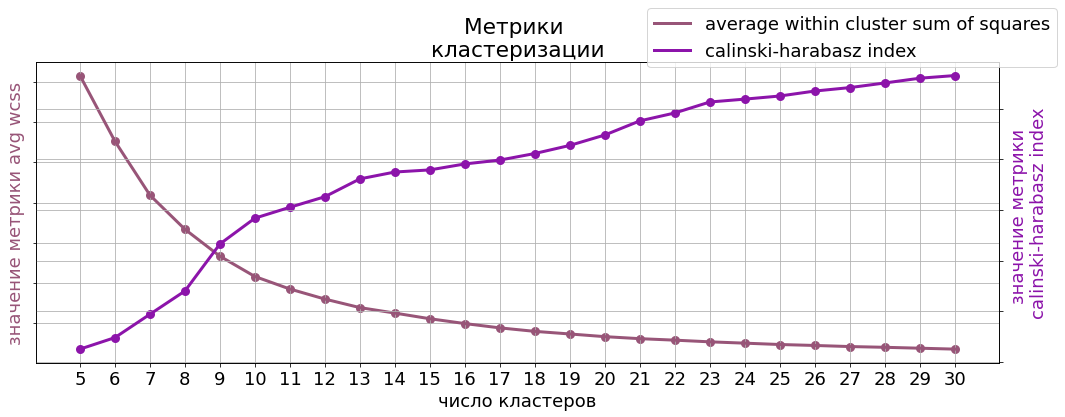

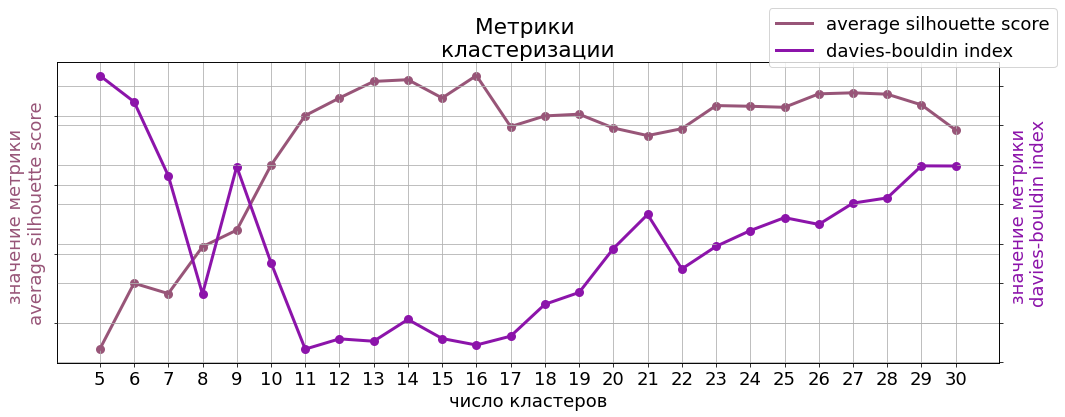

In [107]:
algo_wcss = [res_scores[key]['average within cluster sum of squares'] for key in res_scores.keys()]
algo_ch = [res_scores[key]['calinski-harabasz index'] for key in res_scores.keys()]
algo_db = [res_scores[key]['davies-bouldin index'] for key in res_scores.keys()]
algo_ass = [res_scores[key]['average silhouette score'] for key in res_scores.keys()]


# PLOT 1
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.set_xlabel('число кластеров')
ax1.set_ylabel('значение метрики avg wcss', color='#985578')
ax1.set_yticklabels([])
ax1.plot(cluster_count, algo_wcss, linewidth=3, color='#985578', label='average within cluster sum of squares')
ax1.scatter(cluster_count, algo_wcss, linewidth=3, color='#985578')
ax1.tick_params(axis='y', labelcolor='#985578')

ax2 = ax1.twinx()
ax2.set_ylabel('значение метрики \ncalinski-harabasz index', color='#8C14AA')
ax2.set_yticklabels([])
ax2.plot(cluster_count, algo_ch, linewidth=3, color='#8C14AA', label='calinski-harabasz index')
ax2.scatter(cluster_count, algo_ch, linewidth=3, color='#8C14AA')
ax2.tick_params(axis='y', labelcolor='#8C14AA')

plt.title('Метрики \nкластеризации')
plt.xticks(cluster_count)
ax1.grid()
ax2.grid()
fig.legend()
plt.tight_layout()
plt.show()


# PLOT 2
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.set_xlabel('число кластеров')
ax1.set_ylabel('значение метрики \naverage silhouette score', color='#985578')
ax1.set_yticklabels([])
ax1.plot(cluster_count, algo_ass, linewidth=3, color='#985578', label='average silhouette score')
ax1.scatter(cluster_count, algo_ass, linewidth=3, color='#985578')
ax1.tick_params(axis='y', labelcolor='#985578')

ax2 = ax1.twinx()
ax2.set_ylabel('значение метрики \ndavies-bouldin index', color='#8C14AA')
ax2.set_yticklabels([])
ax2.plot(cluster_count, algo_db, linewidth=3, color='#8C14AA', label='davies-bouldin index')
ax2.scatter(cluster_count, algo_db, linewidth=3, color='#8C14AA')
ax2.tick_params(axis='y', labelcolor='#8C14AA')

plt.title('Метрики \nкластеризации')
plt.xticks(cluster_count)
ax1.grid()
ax2.grid()
fig.legend()
plt.tight_layout()
plt.show()

In [113]:
# 11, 14, 17
import libpysal

In [117]:
%%time
cluster_model = AgglomerativeClustering(n_clusters=17, linkage='ward')
df['cluster_label'] = cluster_model.fit_predict(np.radians(df[['del_latitude', 'del_longitude']].values))

CPU times: user 1min 16s, sys: 9.18 s, total: 1min 25s
Wall time: 1min 25s


In [121]:
display(calc_all_metrics(df[['del_latitude', 'del_longitude']].values, df['cluster_label'].values))

{'average within cluster sum of squares': 88.7387,
 'average silhouette score': 0.397,
 'calinski-harabasz index': 44935.0716,
 'davies-bouldin index': 0.6914}

In [118]:
res_dict = {}
for cluster_name in tqdm(set(df['cluster_label'].unique())):
    
    coords = df[df['cluster_label'] == cluster_name][['del_longitude', 'del_latitude']].values
    
    
    if cluster_name in [
#         '0_cluster', 
    ]:
        continue
    try:
        
        alpha_shape = libpysal.cg.alpha_shape_auto(coords)
        res_dict[cluster_name] = str(alpha_shape)
    
    except:
        print(len(coords))

100%|██████████| 17/17 [00:16<00:00,  1.02it/s]


In [119]:
with open('../data/map_clusters_config.json', 'r') as file:
    map_2_config = json.load(file)

In [122]:
# pd.DataFrame(pd.Series(res_dict)).reset_index(drop=False).rename({0: 'f'}, axis=1).to_csv('../data/clusters_poly_aggclust.csv', index=False)

In [123]:
poly_clusters = pd.read_csv('../data/clusters_poly_aggclust.csv')

In [125]:
map_2 = KeplerGl(height=700, config=map_2_config)
map_2.add_data(df[['del_latitude', 'del_longitude', 'cluster_label']], name='s2')
map_2.add_data(poly_clusters, name='s1')
map_2

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '7j8vl7h', 'type': …

## Алгоритм 4

* Density-based 
* DBSCAN

In [127]:
from sklearn.cluster import DBSCAN

In [156]:
%%time

coords = df[['del_latitude', 'del_longitude']].values

kms_per_radian = 6371.00882
epsilon = 0.27 / kms_per_radian

db = DBSCAN(
    eps=epsilon,
    min_samples=10,
    algorithm='ball_tree',
    metric='euclidean'
).fit(np.radians(coords))

df['cluster_label'] = db.labels_
num_clusters = df['cluster_label'].nunique()

print(num_clusters)

292
CPU times: user 204 ms, sys: 4.85 ms, total: 209 ms
Wall time: 208 ms


In [ ]:
#  'algorithm',
#  'components_',
#  'core_sample_indices_',
#  'eps',
#  'fit',
#  'fit_predict',
#  'get_params',
#  'labels_',
#  'leaf_size',
#  'metric',
#  'metric_params',
#  'min_samples',
#  'n_features_in_',
#  'n_jobs',
#  'p',
#  'set_params']

In [157]:
res_dict = {}
for cluster_name in tqdm(set(df['cluster_label'].unique())):
    
    coords = df[df['cluster_label'] == cluster_name][['del_longitude', 'del_latitude']].values
    
    
    if cluster_name in [
#         '0_cluster', 
    ]:
        continue
    try:
        
        alpha_shape = libpysal.cg.alpha_shape_auto(coords)
        res_dict[cluster_name] = str(alpha_shape)
    
    except:
        print(len(coords))

 49%|████▉     | 143/292 [00:19<00:02, 53.41it/s]

37


 85%|████████▌ | 249/292 [00:20<00:00, 145.51it/s]

13
10


 93%|█████████▎| 271/292 [00:20<00:00, 165.32it/s]

10


100%|██████████| 292/292 [00:22<00:00, 13.09it/s] 


In [158]:
poly_clusters = pd.DataFrame(pd.Series(res_dict)
            ).reset_index(drop=False).rename({0: 'f'}, axis=1
                                            )

In [183]:
# with open('../data/map_clusters_config_ending.json', 'w') as file:
#     json.dump(map_2.config, file)

In [184]:
with open('../data/map_clusters_config_ending.json', 'r') as file:
    map_2_config = json.load(file)

In [178]:
poly_clusters = poly_clusters[poly_clusters['index'] != -1]
poly_clusters['area'] = poly_clusters['f'].apply(lambda x: wkt.loads(x).area)
poly_clusters = poly_clusters[(poly_clusters['index'] != -1) 
                              & (poly_clusters['area'] > 0.00002)
                             ]

# poly_clusters.to_csv('../data/clusters_poly_dbscan.csv', index=False)

In [185]:
map_2 = KeplerGl(height=700, config=map_2_config)
map_2.add_data(df[['del_latitude', 'del_longitude', 'cluster_label']], name='s2')
map_2.add_data(poly_clusters, name='s1')
map_2

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '7j8vl7h', 'type': …

## Алгоритм 5

* distribution - based
* KDE (с изменениями)